# Data Preparation
In this notebook all data preparation steps will be taken with the end goal to produce a clean and ready to use dataset

First step is to load the libraries and set global variables

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

SEED=42

Now the data can be loaded. The labels will be stored initially in the dataframe and the paths to images will be added later. The seperator used in the csv is a tab

In [2]:
image_dir = '../data/toy_dataset/'
labels_path = '../data/toy_dataset_label.csv'

df = pd.read_csv(labels_path, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43455 entries, 0 to 43454
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         43455 non-null  int64 
 1   FILE       43454 non-null  object
 2   AUTHOR     43455 non-null  object
 3   BORN-DIED  43455 non-null  object
 4   TITLE      43455 non-null  object
 5   DATE       43455 non-null  object
 6   TECHNIQUE  43455 non-null  object
 7   LOCATION   43455 non-null  object
 8   FORM       43455 non-null  object
 9   TYPE       43455 non-null  object
 10  SCHOOL     43455 non-null  object
 11  TIMELINE   43455 non-null  object
 12  URL        43455 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.3+ MB


In [3]:
df.sample(n=3)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL
22587,22588,22588.jpg,"LUINI, Bernardino","(b. 1480, Luino, d. 1532, Milano)",Salome Receiving the Head of St John the Baptist,-,"Oil on canvas, 62 x 55 cm","Musée du Louvre, Paris",painting,religious,Italian,1501-1550,http://www.wga.hu/html/l/luini/father/2/salome...
29020,29021,29021.jpg,"OUDRY, Jean-Baptiste","(b. 1686, Paris, d. 1755, Beauvais)","Still-Life with a Partridge, a Hare and Hollyhock",1718,"Oil on canvas, 81 x 87 cm",Private collection,painting,still-life,French,1701-1750,http://www.wga.hu/html/o/oudry/father/stil_lif...
37682,37683,37683.jpg,"TIEPOLO, Giovanni Battista","(b. 1696, Venezia, d. 1770, Madrid)",The Institution of the Rosary,1737-39,"Fresco, 1200 x 450 cm","Santa Maria del Rosario (Gesuati), Venice",painting,religious,Italian,1701-1750,http://www.wga.hu/html/t/tiepolo/gianbatt/2_ge...


The labels are loaded succesfully.

## Select Data

### Columns
The columns that need to be included are:
- ID
- FORM (Only for filtering)
- TYPE
- FILE

With these columns a good first modeling phase can be started too see technical viability

In [4]:
# From the .info() it was visible that FILE has one NaN value
df = df.dropna(subset=['FILE'])

# Create a dataframe with only the relevant columns
columns_to_keep = ['ID', 'FORM', 'TYPE', 'FILE']
df = df[columns_to_keep]

df.info()
df.sample(n=3)

<class 'pandas.core.frame.DataFrame'>
Index: 43454 entries, 0 to 43453
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      43454 non-null  int64 
 1   FORM    43454 non-null  object
 2   TYPE    43454 non-null  object
 3   FILE    43454 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


,ID,FORM,TYPE,FILE
24287,24288,painting,religious,24288.jpg
3013,3014,painting,religious,3014.jpg
34591,34592,painting,landscape,34592.jpg


### Rows
- Rows where the `FORM` equals `painting` will be kept
- The `TYPE` rows will be filtered to only include `religious`, `portrait`, `landscape`, and `mythological`

In [5]:
# Before this operation the values have to be normalized 
df['FORM'] = df['FORM'].astype(str).str.strip().str.lower()
df['TYPE'] = df['TYPE'].astype(str).str.strip().str.lower()

types_to_keep = ['religious', 'portrait', 'landscape', 'mythological']
df = df[df['TYPE'].isin(types_to_keep)]

df = df[
    (df['FORM'] == 'painting') &
    (df['TYPE'].isin(types_to_keep))
]

df.info()
df.sample(n=3)

<class 'pandas.core.frame.DataFrame'>
Index: 23697 entries, 0 to 43446
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      23697 non-null  int64 
 1   FORM    23697 non-null  object
 2   TYPE    23697 non-null  object
 3   FILE    23697 non-null  object
dtypes: int64(1), object(3)
memory usage: 925.7+ KB


,ID,FORM,TYPE,FILE
25841,25842,painting,religious,25842.jpg
22951,22952,painting,landscape,22952.jpg
40065,40066,painting,religious,40066.jpg


Now that the filter is applied the FORM column can be dropped. This holds no extra information for the model to use as it is only one repeated value

In [6]:
df = df.drop('FORM', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23697 entries, 0 to 43446
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      23697 non-null  int64 
 1   TYPE    23697 non-null  object
 2   FILE    23697 non-null  object
dtypes: int64(1), object(2)
memory usage: 740.5+ KB


The amount of rows (`23697`) is too high to get initial insights, it is also not evenly distributed as seen in the EDA

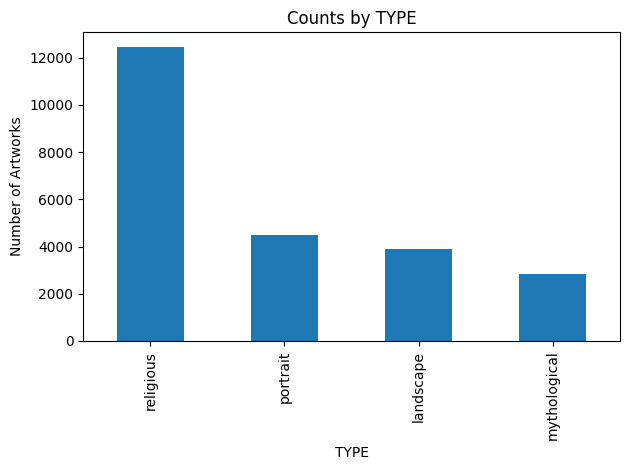

In [7]:
plt.figure()
df['TYPE'].value_counts().plot.bar()
plt.title('Counts by TYPE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

For every type there should be `500` rows for a good initial insight into model performance and make model fine tuning feasible.

In [8]:
n_samples = 500

# 200 random samples from each TYPE
df = df.groupby('TYPE', group_keys=False).apply(lambda x: x.sample(n=n_samples, random_state=SEED))

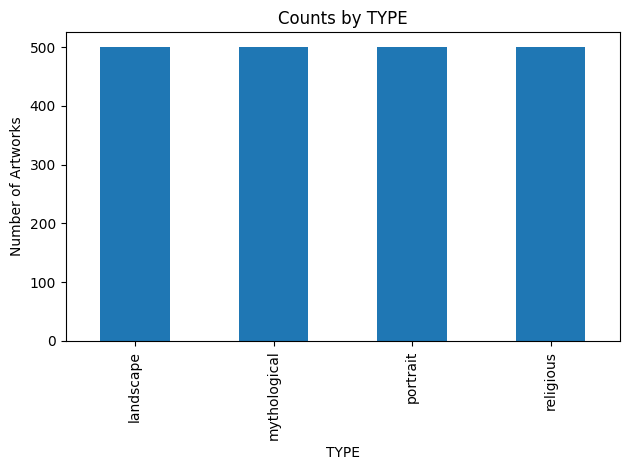

In [9]:
plt.figure()
df['TYPE'].value_counts().plot.bar()
plt.title('Counts by TYPE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

Now the relevant data has been selected the index will be reset

In [10]:
df = df.reset_index(drop=True)
df.sample(n=5, random_state=SEED)

,ID,TYPE,FILE
1860,23306,religious,23306.jpg
353,34203,landscape,34203.jpg
1333,18417,portrait,18417.jpg
905,13165,mythological,13165.jpg
1289,17128,portrait,17128.jpg


## Clean Data
All columns will be transformed to lowercase. Checks will be implemented that throw an error if any value is not lowercase or includes any unwanted spaces

In [11]:
df.columns = [col.lower() for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   type    2000 non-null   object
 2   file    2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [12]:
def check_df_string_cleanliness(df):
    # Check all string/object columns
    for col in df.select_dtypes(include=['object', 'string']):
        col_notnull = df[col].dropna()
        # Check for lowercase
        if not col_notnull.apply(lambda x: x == x.lower()).all():
            raise ValueError(f"Column '{col}' contains non-lowercase string values.")
        # Check for leading/trailing whitespace
        if not col_notnull.apply(lambda x: x == x.strip()).all():
            raise ValueError(f"Column '{col}' contains leading or trailing whitespace.")
    print("All string values are lowercase and have no leading/trailing whitespace")

check_df_string_cleanliness(df)

All string values are lowercase and have no leading/trailing whitespace


All column names and values within the rows are now lowercase and without spaces. 

The last step is to change the DType for `form` and `type` to categorical

In [13]:
categorical_cols = ['type']

for col in categorical_cols:
    df[col] = df[col].astype('category')
    print(f"Number of unique values for column {col}: {df[col].nunique()}")

df.info()

Number of unique values for column type: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2000 non-null   int64   
 1   type    2000 non-null   category
 2   file    2000 non-null   object  
dtypes: category(1), int64(1), object(1)
memory usage: 33.5+ KB


## Construct Data

From the `file` column an `image_path` column can be created to load the images at the moment they are needed from the central storage

In [14]:
df['image_path'] = df['file'].apply(lambda x: os.path.join(image_dir, x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          2000 non-null   int64   
 1   type        2000 non-null   category
 2   file        2000 non-null   object  
 3   image_path  2000 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 49.2+ KB


The file column will be dropped as to not have duplicate information

In [15]:
df = df.drop('file', axis=1)

In [16]:
def check_df_image_path(df, image_path_col):
# Check if image paths exist and are valid
    if image_path_col in df.columns:
        missing_paths = df[~df[image_path_col].dropna().apply(os.path.exists)]
        if not missing_paths.empty:
            raise ValueError(
                f"Some paths in '{image_path_col}' do not exist. Example(s):\n{missing_paths[image_path_col].head()}"
            )
        print(f"All paths in '{image_path_col}' exist and are correctly formatted.")
    else:
        print(f"Column '{image_path_col}' not found in DataFrame.")


check_df_image_path(df=df, image_path_col='image_path')

All paths in 'image_path' exist and are correctly formatted.


From the EDA it is known that 2 rows did not have an image available. With the above check it is confirmed that those images are not part of this subset.

## Integrate Data

During this iteration there is no;
- merging or external tables
- no aggregating or grouping
- no joins

## Format Data

Here the dataset is finalized for modeling by performing the following:

- One-hot encoding of categorical variables (`type`) for compatibility with machine learning models
- Shuffling the dataframe to avoid ordering bias during training and validation splits
- Documenting image resizing to ensure compatibility with CNN models

In [17]:
# one hot encoding
df_encoded = pd.get_dummies(df, columns=['type'])

# Shuffle
df_encoded = df_encoded.sample(frac=1, random_state=SEED).reset_index(drop=True)

df_encoded.sample(n=3, random_state=SEED)

,id,image_path,type_landscape,type_mythological,type_portrait,type_religious
1860,10448,../data/toy_dataset/10448.jpg,False,False,False,True
353,35713,../data/toy_dataset/35713.jpg,False,False,False,True
1333,8843,../data/toy_dataset/8843.jpg,False,True,False,False


**Image REsizing**

For compatibility with CNNs all images must be standardized to a fixed size. This is currently not the case as seen in the EDA

To maximize flexibility and avoid unnecessary disk usage images will be resized on the fly during model training and inference. No image files will be modified or overwritten during the data preparation

The image resizing function will be defined and applied as part of the pipeline in the modeling phase

In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2000 non-null   int64 
 1   image_path         2000 non-null   object
 2   type_landscape     2000 non-null   bool  
 3   type_mythological  2000 non-null   bool  
 4   type_portrait      2000 non-null   bool  
 5   type_religious     2000 non-null   bool  
dtypes: bool(4), int64(1), object(1)
memory usage: 39.2+ KB


# Saving the dataframe

In [19]:
output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)

pkl_path = os.path.join(output_dir, "prepared_art500k_subset_paintings.pkl")
df_encoded.to_pickle(pkl_path)

print(f"DataFrame successfully saved to {pkl_path}")

DataFrame successfully saved to ../data/processed/prepared_art500k_subset_paintings.pkl
